In [29]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import pickle

import swimAD2 as ad2       # copy swimAD2.py to your working directory
import time

ad2.disconnect()            # close all instances before connecting
zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

In [30]:
# Create a DC current to charge the capacitor. 

# Measurements of the components. 
Res = 1000 # Resistance in Ohms.
Cap = 10e-6 # Capacitance in Fahrads.

t_wait = -Res*Cap*np.log(1e-6) # Expected time to charge. 
print(t_wait)

hertz = 100e6 # Sampling rate of oscilloscope in Hz. 

volt_in = range(3,6)
n_trial = range(1)

input_dict = {}
for volt in volt_in: 
    input_dict[volt] = {}
    for trial in n_trial:
        trial = str(trial+1)+"th"
        input_dict[volt][trial] = {
                                    "rise": "Charging",
                                    "fall":"Leakage"
                                    }
print(input_dict)

0.13815510557964275
{3: {'1th': {'rise': 'Charging', 'fall': 'Leakage'}}, 4: {'1th': {'rise': 'Charging', 'fall': 'Leakage'}}, 5: {'1th': {'rise': 'Charging', 'fall': 'Leakage'}}}


In [33]:
delay = 10 # Seconds of measurement

for volt in tqdm(input_dict.keys()):
    for trial in n_trial:
        trial = str(trial+1)+"th"

        ad2.config_wavegen(zoroku, 
            frequency=0,
            amplitude=0,
            offset=volt
            )

        ad2.config_oscilloscope(zoroku,
            range0=.25,
            range1=.25,
            sample_rate = 100e3,
            sample_size= int(100e3*delay),
            )
        
        ad2.start_wavegen(zoroku,channel=0)
        input_dict[volt][trial]["rise"] = ad2.measure_oscilloscope(zoroku)
        
        # We let the capacitor charge up
        time.sleep(60)

        input_dict[volt][trial]["fall"] = ad2.measure_oscilloscope(zoroku)

        ad2.stop_wavegen(zoroku,channel=0)
        time.sleep(60*5)


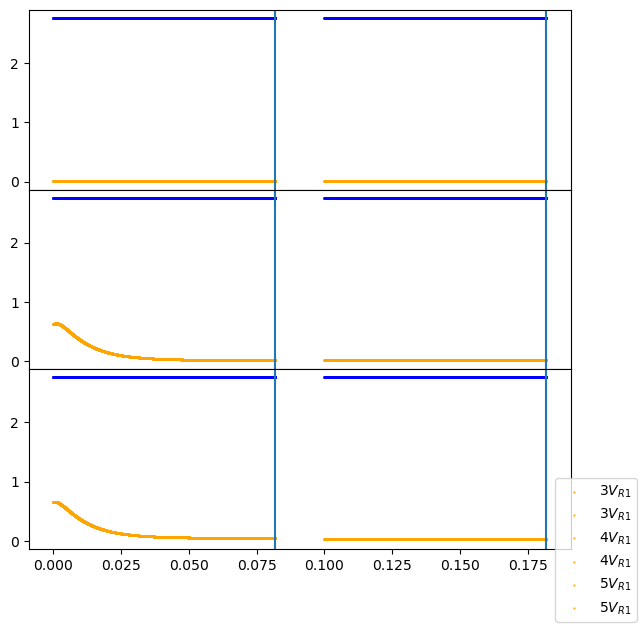

In [43]:
fig, axes = plt.subplots(
                        len(volt_in),len(n_trial),
                        figsize=(7,7),sharex=True,sharey=True
                        )
fig.subplots_adjust(hspace=0,wspace=0.1)

for i,volt in enumerate(volt_in):
    # ax = axes[i]
    for trial in n_trial:
        trial = str(trial+1)+"th"
        for region in ["rise","fall"]:
            t,v0,v1 = input_dict[volt][trial][region]

            axes[i].scatter(t,v0,
                              color="orange",s=0.3,
                              label=str(volt)+"$V_{R1}$"
                              )
            axes[i].axvline(x=t[-1])
            axes[i].scatter(t,v1,
                              color="blue",s=0.3)
fig.legend(loc="lower right")


In [44]:
handle = open("rc-practice.pkl", 'wb')
pickle.dump(input_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

In [46]:
for i,volt in enumerate(volt_in):
    for trial in n_trial:
        trial = str(trial+1)+"th"

        region = "fall"
        t,v0,v1 = input_dict[volt][trial][region]
        print(np.mean(v0)*Res)

7.639423714992035
27.16346052780374
43.42013236290518
